In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import struct
from array import array
from os.path  import join
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 


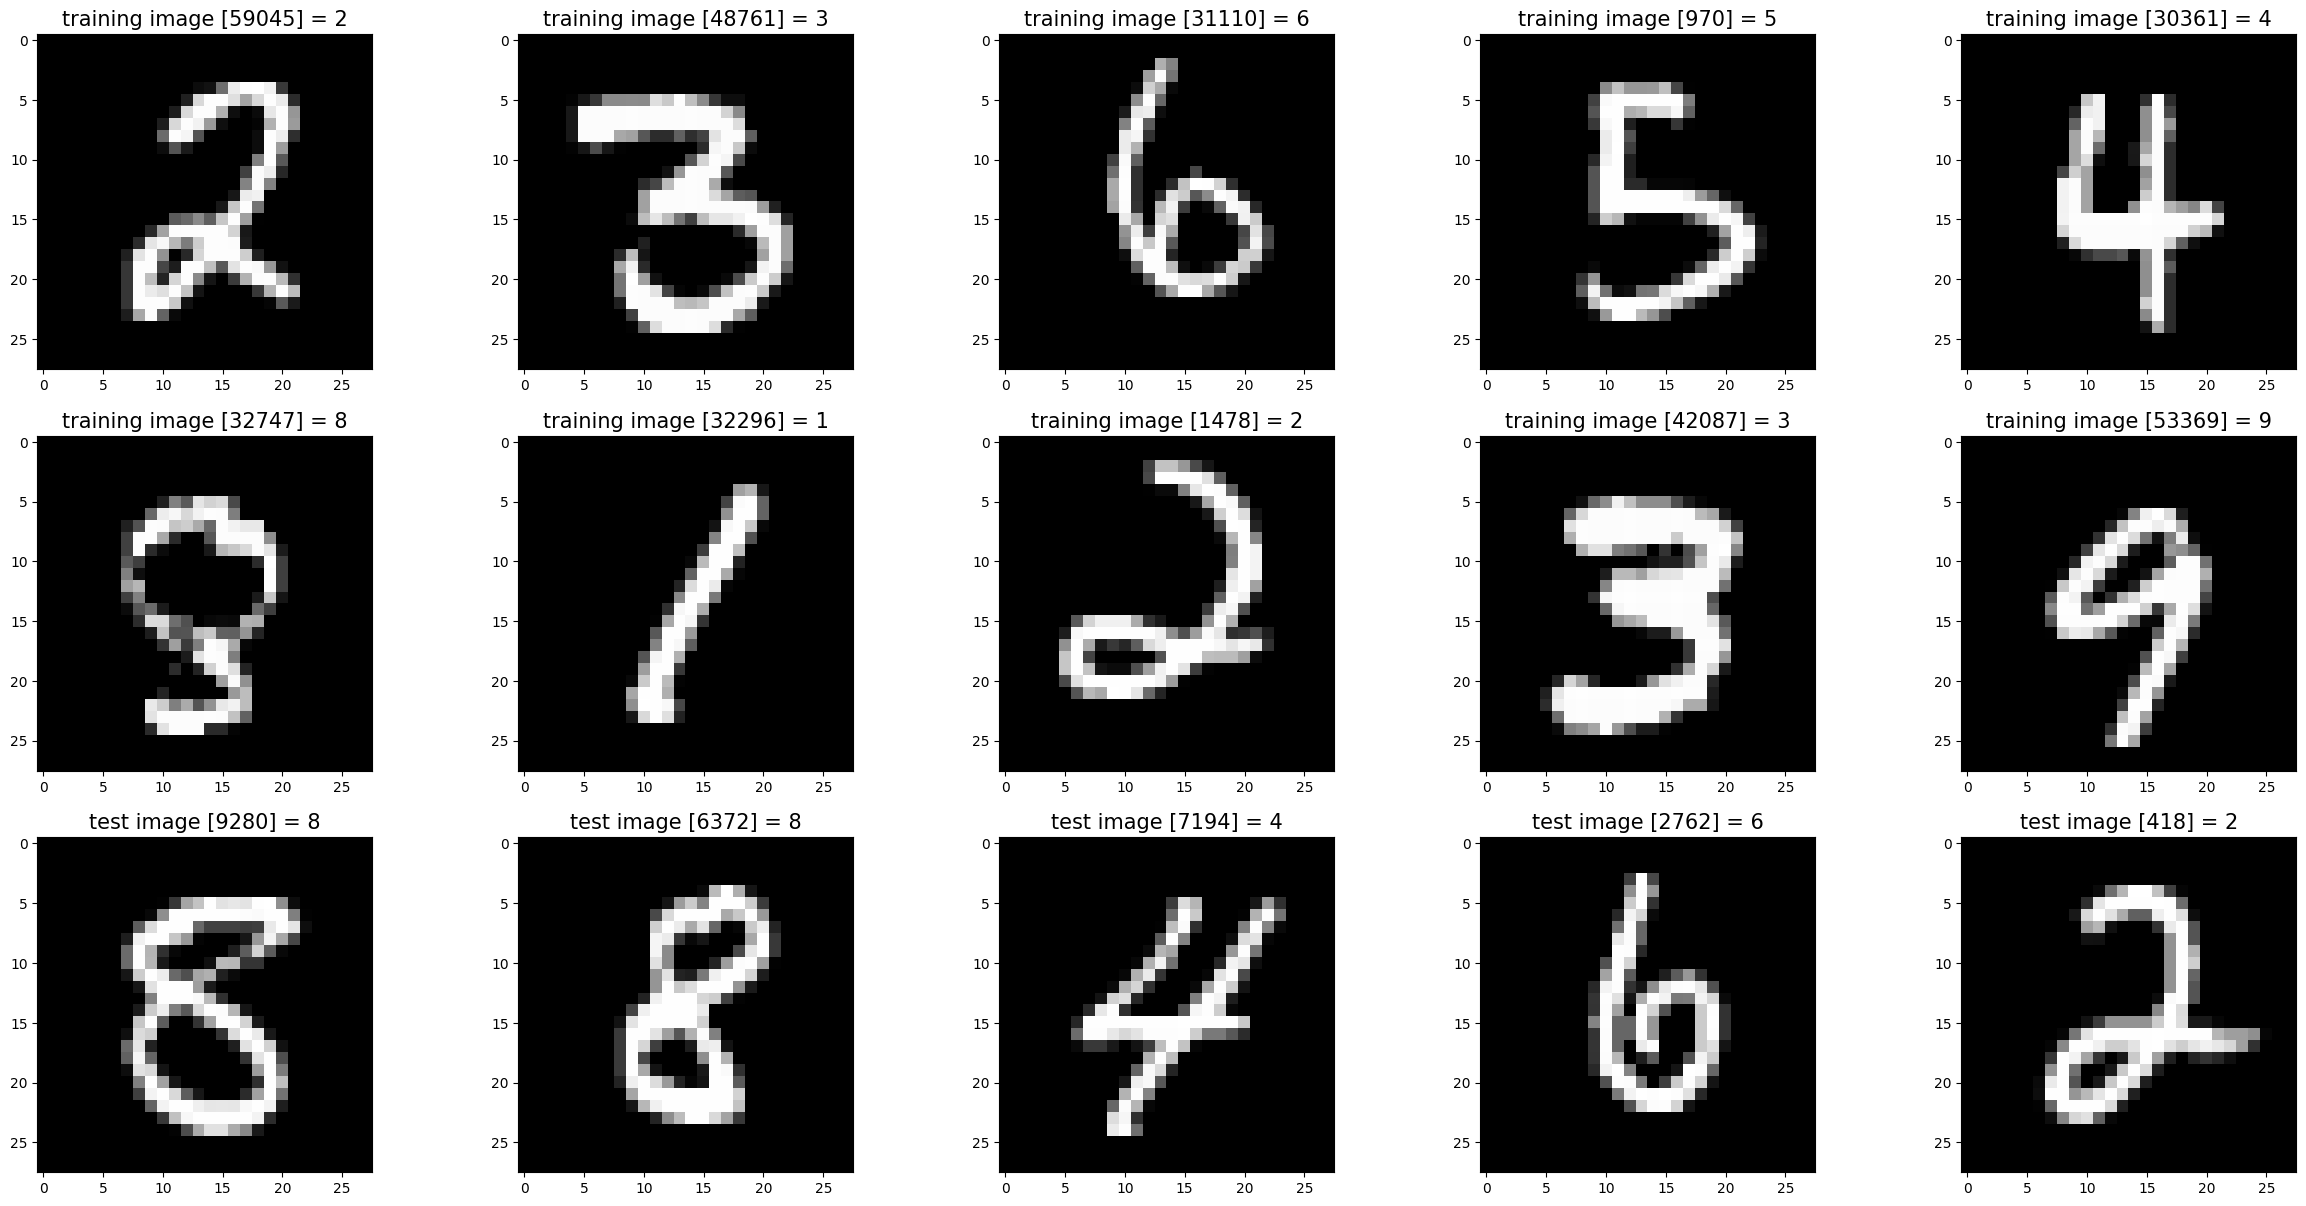

In [17]:
input_path = './mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = np.random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = np.random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [18]:
for i in range(len(x_train)):
    x_train[i] = np.hstack(x_train[i], dtype=float) / 255

for i in range(len(x_test)):
    x_test[i] = np.hstack(x_test[i], dtype=float) / 255

In [15]:
set([x_train[i].shape for i in range(len(x_train))])

{(784,)}

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=[128, 64], activation='relu', alpha=0.001, 
                    learning_rate='invscaling', max_iter=200, verbose=True)
mlp.fit(x_train, y_train)

Iteration 1, loss = 0.39219184
Iteration 2, loss = 0.16270337
Iteration 3, loss = 0.11456065
Iteration 4, loss = 0.08578258
Iteration 5, loss = 0.06883109
Iteration 6, loss = 0.05788587
Iteration 7, loss = 0.04680026
Iteration 8, loss = 0.04111804
Iteration 9, loss = 0.03450189
Iteration 10, loss = 0.02758213
Iteration 11, loss = 0.02498477
Iteration 12, loss = 0.02053562
Iteration 13, loss = 0.01690076
Iteration 14, loss = 0.01638461
Iteration 15, loss = 0.01607037
Iteration 16, loss = 0.01506059
Iteration 17, loss = 0.01489529
Iteration 18, loss = 0.01018730
Iteration 19, loss = 0.00701146
Iteration 20, loss = 0.00815498
Iteration 21, loss = 0.01034143
Iteration 22, loss = 0.01339582
Iteration 23, loss = 0.00943792
Iteration 24, loss = 0.00570595
Iteration 25, loss = 0.01165033
Iteration 26, loss = 0.00995088
Iteration 27, loss = 0.00831875
Iteration 28, loss = 0.00462023
Iteration 29, loss = 0.00363468
Iteration 30, loss = 0.00331066
Iteration 31, loss = 0.00320924
Iteration 32, los

MLPClassifier(alpha=0.001, hidden_layer_sizes=[128, 64],
              learning_rate='invscaling', verbose=True)

In [53]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV


mlp = MLPClassifier(max_iter=200, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(256,), (512,), (128, 64), (256, 128)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
}

scorer = make_scorer(f1_score, average='weighted')

rs = RandomizedSearchCV(mlp, param_grid, n_iter=5, scoring=scorer, cv=5, n_jobs=-1)
rs.fit(x_train, y_train)

rs.best_params_

{'solver': 'adam',
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (256, 128),
 'alpha': 0.0001,
 'activation': 'relu'}

In [21]:
mlp = MLPClassifier(solver='adam', learning_rate='invscaling', hidden_layer_sizes=(256, 128), 
                    alpha=0.0001, activation='relu', max_iter=200, random_state=42)
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(256, 128), learning_rate='invscaling',
              random_state=42)

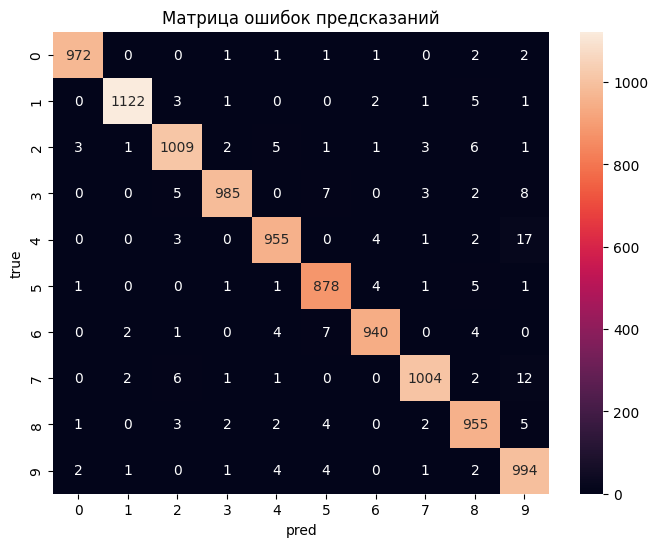

In [22]:
y_pred = mlp.predict(x_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True)
plt.xlabel('pred')
plt.ylabel('true')
plt.title('Матрица ошибок предсказаний');

In [23]:
(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'), 
 recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'))

(0.9814, 0.9815431977397328, 0.9814, 0.9814280723779546)